# Architecture

![Screenshot](./flow_diagram.png)

In [1]:
from langchain_community.document_loaders.csv_loader import CSVLoader #To load the csv file (data containing companys faq)
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint,HuggingFaceEmbeddings # Load the llm and embedding model from huggingface
from langchain_chroma import Chroma #Vectorstore to store the embedded vectors
from langchain_core.prompts import PromptTemplate
from langchain.chains import create_retrieval_chain # "Combines a retriever (to fetch docs) with the 'create_stuff_document_chain' to automate end-to-end retrieval + answering."
from langchain.chains.combine_documents import create_stuff_documents_chain #"Formats retrieved documents + question into a prompt and passes it to the LLM for answering."
from langchain_core.tools import tool # To create a custom tool
from langchain_community.tools import DuckDuckGoSearchRun

import warnings
warnings.filterwarnings('ignore')

## Step-1 Load the data (company_Q1.csv)

#### load the CSV file that Contains the FAQ question regarding the company

In [2]:
file_path = "./company_QA.csv" #Path to the file
loader = CSVLoader(file_path=file_path) #CSVLoader to load the CSV file
docs = []
for doc in loader.lazy_load(): #Perfom lazy load
    docs.append(doc)


In [3]:
len(docs) # Total number of document object

59

In [4]:
docs[0] #first document object

Document(metadata={'source': './company_QA.csv', 'row': 0}, page_content="Question: Where is the company's headquarters located?\nAnswer: Our headquarters is located in San Francisco, California. Nestled in the vibrant downtown area, it provides easy access to public transport and major city landmarks.")

### Note : No need to performing chunking since each document object is a single row of the CSV file

## Step-2 Load the LLM and Embedding model from HuggingFace

In [ ]:
# Load the Mistral 7b model 
repo_id = "mistralai/Mistral-7B-Instruct-v0.3"  #Repo for mistral
api_key = "" #Api key to access the hugging face(Please use your own API Key)
llm = HuggingFaceEndpoint(
    repo_id = repo_id,
    huggingfacehub_api_token=api_key,
    temperature = 0.3, 
    max_new_tokens=200   # Max number of tokens to generate in the final output

)
model = ChatHuggingFace(llm=llm)

# Test the model if working properly
model.invoke("who is messi ?")

AIMessage(content="Lionel Messi is a world-renowned professional footballer (soccer player) from Argentina. He currently plays for Paris Saint-Germain F.C. in the French Ligue 1 and captains the Argentina national team. Messi is widely regarded as one of the greatest footballers of all time. He spent the majority of his illustrious career at FC Barcelona, where he won numerous titles, including multiple Spanish La Liga and UEFA Champions League titles, as well as several personal awards, including the FIFA World Player of the Year and the Ballon d'Or awards multiple times. Messi is known for his exceptional dribbling, passing, and scoring abilities, making him a dual threat both individually and for the team. His speed, precision, and creativity have been key factors in his success on the pitch.", additional_kwargs={}, response_metadata={'token_usage': ChatCompletionOutputUsage(completion_tokens=172, prompt_tokens=8, total_tokens=180), 'model': '', 'finish_reason': 'stop'}, id='run-523

In [6]:
#Loading the embedding model 
embedding_model = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")

## Step-3 Creating a Vectorstore and a retriever

#### a. Chroma vector store to store the embedding vectors
#### b. retriever to fetch the relevant documents based on user query from vectorstore

In [7]:
# Creating and added documents to vector store
db = Chroma.from_documents(docs,  #Document object 
                            embedding_model) #Huggingface embedding model

In [8]:
# Creating a retriever
retriever = db.as_retriever(search_type = "mmr"  #Maximux-marginal-relevance 
                            ,search_kwargs = {'k':2,'lambda_mult':0.4} # 'k': select top 2 similar documents and 'lambda_mult': for diverse documents 
                            )

In [9]:
# Test how well is the retriever working 
query = "What is the leave policy for the intern ?"
result = retriever.invoke(query)
for index , res in enumerate(result):
    print(f"---Document-{index+1}")
    print(res.page_content)

---Document-1
Question: Can interns take leave?
Answer: Interns accrue 1 day/month after 3 months of service.
---Document-2
Question: Are there COVID-19 protocols currently in place?
Answer: We adhere to the latest health guidelines, including optional mask use, hand sanitation stations throughout the facility, and enhanced cleaning schedules.


## Step-4 Creating a prompt template

In [10]:
template = PromptTemplate(
    template = """You are a helpful AI assistance.Please answer the given user question only based on the context provided. 
'context'
{context}
'user question'
{input}""",
input_variables=['context','input']
)

## Step-5 Create a Chain 

#### Creating a RAG_Chain by combining components like 'prompt template' , 'retriever' etc

In [11]:
# To create a chain that "Formats retrieved documents + question into a prompt and passes it to the LLM for answering."
combine_docs_chain = create_stuff_documents_chain(model, template)
# To create a final chain to reterive, format prompt and generate answer 
rag_chain = create_retrieval_chain(retriever, combine_docs_chain) 

In [12]:
# Ask a query to the llm to reg the final response
result = rag_chain.invoke({
    'input':query
})
result['answer']

'The leave policy for an intern is that they accrue 1 day/month after 3 months of service.'

## Step-6 Creating tools 

### Tool A. VectorStore Retriever tool (Convert the rag_chain into a tool)

#### Redirect to this tool if the user queries is regarding the companies HR Policy

### Tool B. DuckDuckSeach Tool

#### Redirect to this tool if the user query is general 


In [13]:
@tool
def retrieve_vectorstore_tool(query:str)->str:
    """RAG solution for a companys HR Policy FAQ"""
    return rag_chain.invoke({'input':query})

In [14]:
search = DuckDuckGoSearchRun()
@tool
def duckducksearch_tool(query:str)->str:
    """Perform duckduck search when user query is other then companies HR policy"""
    return search.invoke(query)


## Step-7 Bind the llm with tools

In [15]:
tools = [retrieve_vectorstore_tool,duckducksearch_tool]
llm_with_tools = model.bind_tools(tools=tools)

In [16]:
llm_with_tools.invoke(query).tool_calls

[{'name': 'retrieve_vectorstore_tool',
  'args': {'query': 'leave policy for intern at [Company_name]'},
  'id': '0',
  'type': 'tool_call'}]

## Step-8 Define the langgraph Workflow

In [17]:
from typing_extensions import Annotated,TypedDict #Annotated for labelling and TypeDict to maintain graph state 
from langchain_core.messages import AnyMessage #Human message or Ai Message
from langgraph.graph.message import add_messages  ## Reducers in Langgraph 

#Schema info that flows through the nodes
class state(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

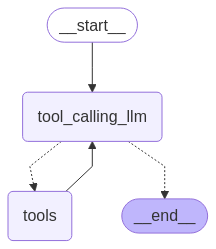

In [18]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode #specialized node designed to execute tools within our workflow.
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display #to visualize the Graph



#Function that decides which tool to use for serving the userquery
def tool_calling_llm(state:state) ->state:
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

# Initialize the StateGraph
builder = StateGraph(state_schema=state)

#Adding Nodes
builder.add_node('tool_calling_llm',tool_calling_llm) #returns the tools that is to be used
builder.add_node('tools',ToolNode(tools=tools)) #Uses the tool specified to fetch result

#Adding Edges
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    # If the latest message from AI is a tool call -> tools_condition routes to tools
    # If the latest message from AI is a not a tool call -> tools_condition routes to LLM, then generate final response and END
    tools_condition
)
builder.add_edge('tools','tool_calling_llm')

#Compile the graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [19]:
response = graph.invoke({
    'messages':"who is messi ?"
})

HfHubHTTPError: 422 Client Error: Unprocessable Entity for url: https://router.huggingface.co/hf-inference/models/mistralai/Mistral-7B-Instruct-v0.3/v1/chat/completions (Request ID: Root=1-680f9292-091791d7299d66712e3d301f;b0f536fb-07d8-4470-86c1-52325d9b4d58)

Template error: syntax error: Tool call IDs should be alphanumeric strings with length 9! (in <string>:81)
{"error":"Template error: syntax error: Tool call IDs should be alphanumeric strings with length 9! (in <string>:81)","error_type":"template_error"}


In [ ]:
llm_with_tools.invoke(query).tool_calls